# GPT-2 124M replication 

We will replicate the 124M version of GPT2 (counted wrongly as 117M in the [paper](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)). Some aspects of the datasets will also be picked up from [gpt3 paper](https://arxiv.org/abs/2005.14165). The original gpt2 code was written in tensorflow but we wish to use the pytorch version, which is much more en vogue. 

We will start backward, by first trying to interact with the pretrained model from [hugging face](https://huggingface.co/openai-community/gpt2). 

In [4]:
from transformers import GPT2LMHeadModel

c:\Users\Anup\Documents\ML\calm-notebooks\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
hf = GPT2LMHeadModel.from_pretrained("GPT2") # 124M, use GPT2-XL for actual 1.5b model
sd_hf = hf.state_dict() # stores parameters

# look at different params in gpt2 and their shape
for k,v in sd_hf.items():
    print(k, v.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

1. __the first param__ `wte` is weight token embedding - which is `(50257,768)` dimensional. this means vocab size is `50257` and embedding length per token is `768`. 

2. Param 2: wpe is the lookup table for positions. `(1024,768)` $\implies$ `1024` context length and `768` dimensional vector for each position. 

In [ ]:
# read this - found it insightful
?GPT2LMHeadModel.from_pretrained

In [12]:
# peek into first 20 weights of positional embeddings
sd_hf["transformer.wpe.weight"].view(-1)[:20]

tensor([-0.0188, -0.1974,  0.0040,  0.0113,  0.0638, -0.1050,  0.0369, -0.1680,
        -0.0491, -0.0565, -0.0025,  0.0135, -0.0042,  0.0151,  0.0166, -0.1381,
        -0.0063, -0.0461,  0.0267, -0.2042])

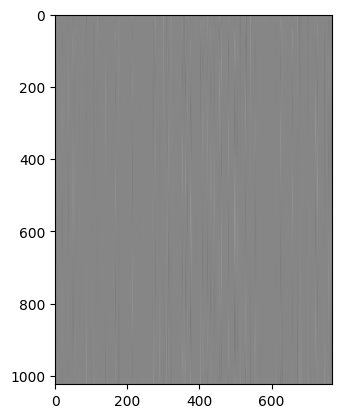

In [16]:
# visualize Position embeddings

import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(sd_hf["transformer.wpe.weight"], cmap="gray")

Lets focus on 3 specific positions to see the vertical patterns in shade better:

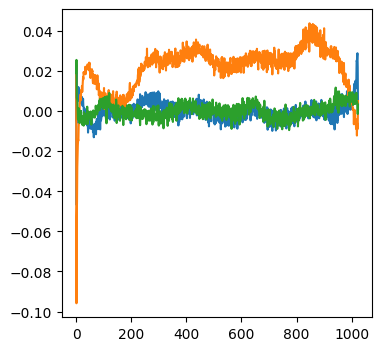

In [ ]:
plt.figure(figsize=(4,4))
plt.plot(sd_hf["transformer.wpe.weight"][:, 150]) # 149th channel across all positions
plt.plot(sd_hf["transformer.wpe.weight"][:, 250]) 
plt.plot(sd_hf["transformer.wpe.weight"][:, 550])
plt.show()

__Andrej's word:__ The jaggedness shows that the model is a bit undertrained. Intuition: init is random so crazy jaggedness is expected. but as you train it becomes smoother. Looks sinosoidal-ish. The fact that gpt2 takes positional encoding to be learnable and arrives at the same result as the original transformer paper (where they assign sinousoidal PE of varying frequency from the start) is interesting. 

What exactly these graphs mean? We can actually see more such graphs while trying to visualize the weights of the heads, layer norms etc - but this is covered in mechanistic interpretability, which is not the scope now at least. 
<hr>

Now that we have loaded the weights of gpt2 124M, lets sample from it using the [hugging face](https://huggingface.co/openai-community/gpt2) 'pipeline':



In [26]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2', truncation = True)
set_seed(42)
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=30) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[{'generated_text': 'Hello, I\'m a language model, but what I\'m really trying to do is make everything a language. And this is where I\'m really happy."\n\nThe language model is similar to the "code" model in Python. It involves only a small number of variables and does not involve any writing code. The language model, in contrast, enables you to write code that is easy to understand, understandable and fast to program.\n\nThe language model can be divided into three parts. The first one is to implement the concepts of the language model in Python and implement the language model in C. This is an important step to understand the language model, but it is not the only step.\n\nThe second piece is to make the compiler and the compiler-environment in Python more robust and easy to understand.\n\nThe third part is to implement the language model in C and to make the compiler and the compiler-environment in Python more robust and easy to understand.\n\nThe final part is to use the language

<span style="color: red; font-weight: bold;">NOTE:</span>

Now lets go on to implement the GPT2 (decoder only) 124M version. The original transformer paper's architecture has encoder+decoder whereas modern LLMs are decoder only. Understand the difference through [this blog](https://www.notion.so/encoder-vs-decoder-models-2896be0e11f180e3af89f54e99d204da?source=copy_link)


## Notes on implementation in load_pretrained_wts.py

[Gaussian Error Linear Units - GeLU]((https://arxiv.org/pdf/1606.08415))
- [Gelu](https://docs.pytorch.org/docs/stable/generated/torch.nn.GELU.html) activation, along with tanh approximation - since in early days of Gelu a reliable approximation of erf() used in gelu didnt exist digitally. 
    - Gelu solves the dead neuron problem as it has a bump around 0 is differentiable, unlike ReLU. 

- Weight tying and its significance (spatial efficiency, lower parameters) between the `lm_head` layer and `wte` (token_embeddings) layer